#Titanic Data

By: Rakpong Kittinaradorn

Date: 5 October 2016

#Goal of this analysis: 

Determine the factors leading to suvivability of passenger abroad Titanic.

In [92]:
# read data

import pandas as pd
import numpy as np
import re

path = r'/Users/rkcosmos/Dropbox/DataAnalystNanodegree/P2/titanic_data.csv'
data = pd.read_csv(path)

First, I perform preliminary exploration by looking at the overall information I have.

In [93]:
data.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Graham, Mr. George Edward",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,NaN,1.000000,0.000000,NaN,31.000000,NaN,NaN


#Data Wrangling Phase: Cleaning Data

In this phase, I'll clean data by dropping Cabin column and add missing data for Embarked and Age column.

###Cabin

Cabin has too many missing data to analyse. I'll drop this column.

In [94]:
data = data.drop('Cabin', 1)

###Embarked

Embarked has 2 missing data. First I'll explore the frequency of Embarked data.

In [95]:
data.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

'S' is the most frequent value. 

In [96]:
data[data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


Looking at the missing data, I found that both has ticket value in the form '113xxx'. I'll check if this pattern provide any insight. I'll also look at Pclass, Sex, Fare.

In [97]:
data_pattern = data[data.Ticket.str.match('(113\d\d\d$)').str.len() > 0]
data_pattern.Embarked.value_counts()

/Users/rkcosmos/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: In future versions of pandas, match will change to always return a bool indexer.
  if __name__ == '__main__':


S    41
C     4
Name: Embarked, dtype: int64

In [98]:
data_pattern = data[data['Fare'] <90][data['Fare'] >70]
data_pattern.Embarked.value_counts()

/Users/rkcosmos/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


S    23
C    19
Name: Embarked, dtype: int64

In [99]:
data_pattern = data[data.Pclass ==1]
data_pattern.Embarked.value_counts()

S    127
C     85
Q      2
Name: Embarked, dtype: int64

In [100]:
data_pattern = data[data.Sex =='female']
data_pattern.Embarked.value_counts()

S    203
C     73
Q     36
Name: Embarked, dtype: int64

From the above information, Embarked value for these 2 passengers are most likely 'S'. I fill them with 'S' using next line of code.

In [101]:
data['Embarked'].fillna('S', inplace=True)

###Age

The last data cleaning is 'Age' column. I fill the missing value with the median age.

In [102]:
data['Age'].fillna(data.Age.median(), inplace=True)

# Exploration Phase

Four factors related to survivalibity are explored in this section using both machine learning and statistical inference.

### Machine Learning: Decision Tree

I am going to use decision tree classifier from sklearn to explore the importance of each feature. Since sklearn cannot have categorical variables as an input, I have to take care of this first. For binary feature (Sex), I will map string (male or female) to integer (1 or 0). For non-binary features (Embarked and Pclass), I cannot map string to integer because it will create an illusion that Embarked C < Embarked Q < Embarked S which is clearly not true. The correct way to do this is to create dummy features for each category and pass these dummy into the classifer 

In [103]:
data['Gender'] = data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

dummyEmbarked = pd.get_dummies(data.Embarked) # This gives 3 new dummy features namely C,Q and S from Embarked
dummyPclass = pd.get_dummies(data.Pclass)   # This gives 3 new dummy features namely 1,2 and 3 from Pclass
data = pd.concat([data, dummyEmbarked, dummyPclass], axis=1)
data.rename(columns={1: 'class 1', 2: 'class 2',3: 'class 3'}, inplace=True)

feature = ['class 1','class 2','class 3','Age','SibSp','Parch','Fare','Gender','C','Q','S']

Next, I fit my data. 

In [104]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(min_samples_split=50,max_depth=3)
clf = clf.fit(data[feature], data['Survived'])

To visualize the result, graphviz and pydot are needed. Note that I have to install the following to make code run properly:

1. brew install graphviz

2. condo install pydot

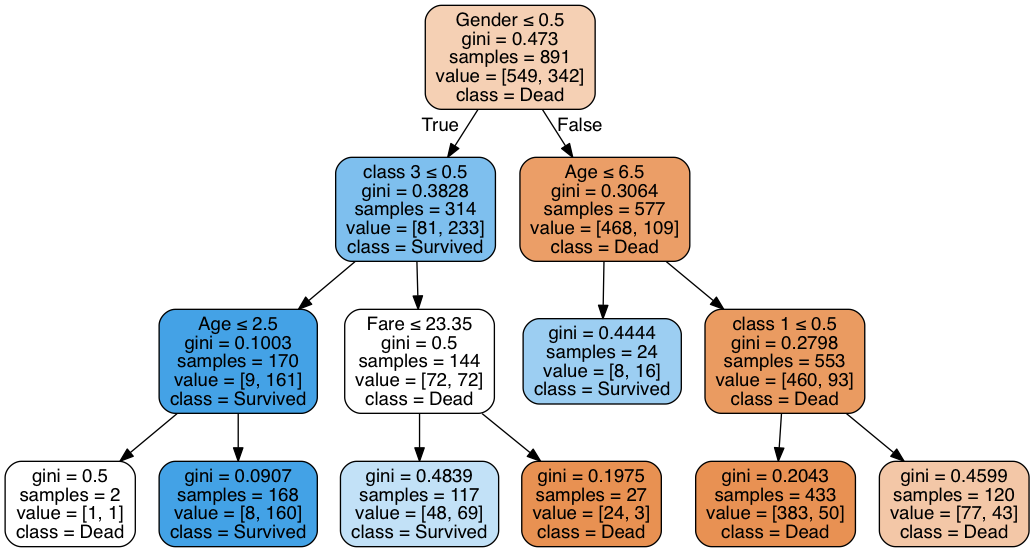

In [105]:
from sklearn.externals.six import StringIO 
import pydot 
from IPython.display import Image 

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data, feature_names=feature,class_names=['Dead','Survived'],filled=True, 
                     rounded=True, special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png(),width=900) 

From the decision tree, the most important factor contributing to survivability are Gender, Class and Age. Next, I'll confirm the importance of these three factors using statistical inference. The factor Embarked is also checked to make sure that it is not contributing to survivability.

###Statistical Inference: Sex

In [106]:
NoMaleSurvive = data[data.Sex=='male'][data.Survived==1].Survived.count()
NoMale =data[data.Sex=='male'].Survived.count()
NoFemaleSurvive = data[data.Sex=='female'][data.Survived==1].Survived.count()
NoFemale = data[data.Sex=='female'].Survived.count()

print 'percentage of male survived =', NoMaleSurvive*100.0/NoMale
print 'percentage of female survived =', NoFemaleSurvive*100.0/NoFemale

percentage of male survived = 18.8908145581
percentage of female survived = 74.2038216561


/Users/rkcosmos/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/Users/rkcosmos/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


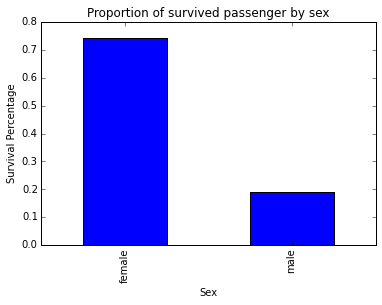

In [107]:
SexProp = data[data.Survived==1].Sex.value_counts()/data.Sex.value_counts()
%matplotlib inline
picSex = SexProp.plot(kind='bar', title='Proportion of survived passenger by sex')
picSex.set_xlabel("Sex")
picSex.set_ylabel("Survival Percentage")

Statistical test is performed to show the above difference in female/male survibility is not due to chance.

Null Hypothesis: Male survibility is equal to female surviility.

Alternative Hypothesis: Male survibility is not equal to female surviility.

In [108]:
from scipy import stats

def PropTest(x1, n1, x2, n2):
    p1 = float(x1)/n1
    p2 = float(x2)/n2
    p = float(x1 +x2)/(n1+n2) # pool sample proportion
    samplestat =  p1 - p2
    se = np.sqrt(p*(1.0-p) * (1.0/n1 + 1.0/n2)) # standard error
    z_score = samplestat/se
    p_value = stats.norm.sf(abs(z_score))*2
    return se,z_score,p_value

print PropTest(NoMaleSurvive,NoMale,NoFemaleSurvive,NoFemale)

(0.034104182418067779, -16.218833930670097, 3.7117477701134797e-59)


With  very small p-value, we can safely reject the null hypothesis.

###Statistical Inference: Embarked

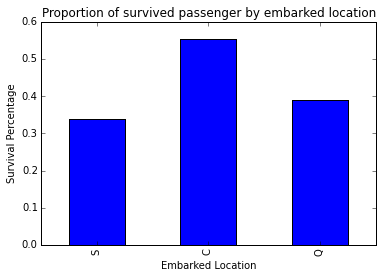

In [109]:
EmbarkedProp = data[data.Survived==1].Embarked.value_counts()/data.Embarked.value_counts()
%matplotlib inline
picEmbark = EmbarkedProp.plot(kind='bar', title='Proportion of survived passenger by embarked location')
picEmbark.set_xlabel("Embarked Location")
picEmbark.set_ylabel("Survival Percentage")

In this section, I will perform chi-square testing for independency between 'Embarked' and 'Survived' variables. My hypothesis are as follow:

Null Hypothesis: Embarked and survibility are independent.

Alternative Hypothesis: Embarked and survibility are not independent.

In [110]:
# Build contingency table

dataS = data[data.Embarked =='S']
dataC = data[data.Embarked =='C']
dataQ = data[data.Embarked =='Q']

columnS = dataS.Survived.value_counts()
columnC = dataC.Survived.value_counts()
columnQ = dataQ.Survived.value_counts()

contingency_table = pd.concat([columnS, columnC,columnQ], axis=1)

print contingency_table

   Survived  Survived  Survived
0       427        75        47
1       219        93        30


In [111]:
chi2,pvalue,dof,expected = stats.chi2_contingency(contingency_table, correction=True)

print chi2, pvalue

25.9644528819 2.30086264814e-06


From p-value = 2.3e-6, I conclude there is a relationship between embarked location and survibility.

###Statistical Inference: Passenger Class

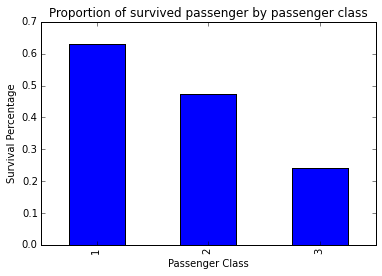

In [112]:
PclassProp = data[data.Survived==1].Pclass.value_counts()/data.Pclass.value_counts()
%matplotlib inline
picPclass = PclassProp.plot(kind='bar', title='Proportion of survived passenger by passenger class')
picPclass.set_xlabel("Passenger Class")
picPclass.set_ylabel("Survival Percentage")

In this section, I will perform chi-square testing for independency between 'Pclass' and 'Survived' variables. My hypothesis are as follow:

Null Hypothesis: Passenger class and survibility are independent.

Alternative Hypothesis: Passenger class and survibility are not independent.

In [113]:
# Build contingency table

column1 = data[data.Pclass ==1].Survived.value_counts()
column2 = data[data.Pclass ==2].Survived.value_counts()
column3 = data[data.Pclass ==3].Survived.value_counts()

contingency_table = pd.concat([column1, column2,column3], axis=1)

# run chi-square test
chi2,pvalue,dof,expected = stats.chi2_contingency(contingency_table, correction=True)

print chi2, pvalue

102.888988757 4.5492517113e-23


###Statistical Inference: Age

In this section, I will perform chi-square testing for independency between 'Age' and 'Survived' variables. My hypothesis are as follow:

Null Hypothesis: Age and survibility are independent.

Alternative Hypothesis: Age and survibility are not independent.

Chi-Square = 24.0362761678 
P-value = 0.00112274308612


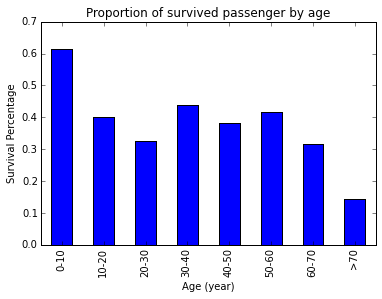

In [114]:
# Build contingency table

dataAge1 = data[data.Age<10].Survived.value_counts()
dataAge2 = data[(data.Age>=10) & (data.Age<20)].Survived.value_counts()
dataAge3 = data[(data.Age>=20) & (data.Age<30)].Survived.value_counts()
dataAge4 = data[(data.Age>=30) & (data.Age<40)].Survived.value_counts()
dataAge5 = data[(data.Age>=40) & (data.Age<50)].Survived.value_counts()
dataAge6 = data[(data.Age>=50) & (data.Age<60)].Survived.value_counts()
dataAge7 = data[(data.Age>=60) & (data.Age<70)].Survived.value_counts()
dataAge8 = data[data.Age>=70].Survived.value_counts()

contingency_table = pd.concat([dataAge1,dataAge2,dataAge3,dataAge4,dataAge5,dataAge6,dataAge7,dataAge8], axis=1)

#print contingency_table

# Plot survibility by age
plot_table = contingency_table.loc[1]/(contingency_table.loc[0]+contingency_table.loc[1])
plot_df = pd.DataFrame(plot_table).transpose()
plot_df.columns = ['0-10', '10-20','20-30','30-40','40-50','50-60','60-70','>70']

%matplotlib inline
picAge = plot_df.iloc[0].plot(kind='bar', title='Proportion of survived passenger by age')
picAge.set_xlabel("Age (year)")
picAge.set_ylabel("Survival Percentage")

# run chi-square test
chi2,pvalue,dof,expected = stats.chi2_contingency(contingency_table, correction=True)

print 'Chi-Square =',chi2,'\nP-value =', pvalue

P-value is lower than 0.05, I can reject the null hypothesis with 95% confidence level.

#Conclusions Phase

From decision tree algorithm, the factors most relevant to survibility are sex, passenger class and age. The other factors those do not appear in decision tree such as embarked location can also be contributing to survibility. I performed statistical inference to confirm that sex, passenger class, age and embarked are correlated to survibility.

#References

Decision tree
1. http://scikit-learn.org/stable/modules/tree.html
2. http://chrisstrelioff.ws/sandbox/2015/06/08/decision_trees_in_python_with_scikit_learn_and_pandas.html

Statistical Testing
3. http://stattrek.com/hypothesis-test/difference-in-proportions.aspx
4. http://stattrek.com/chi-square-test/independence.aspx